In [1]:
import re
import itertools
import collections

import torch
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics import classification_report

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
class DT(torch.utils.data.Dataset):
    def __init__(self, path, margin=1, tokens=None):
        self.tokens = tokens if tokens is not None else {} 
        self.tokens_set = set(self.tokens.keys())

        with open(path, 'r', encoding='utf8') as file:
            print('loading data...')
            lines = file.read().split('\n\n')
            lines = [self.split_words(x) for x in lines if len(x) > 0]

            if margin > 0:
                print('removing length outliers...')
                l = [len(x[0]) for x in lines]
                b1p = np.quantile(l, margin/100, interpolation='nearest')
                t1p = np.quantile(l, (100 - margin)/100, interpolation='nearest')
                lines = [x for x in lines if b1p < len(x[0]) < t1p]

            self.ll = np.array([len(x[0]) for x in lines])
            self.mll = self.ll.max()
            self.wl = np.zeros((self.ll.shape[0], self.mll)).astype(int)
            for i, line in enumerate(lines):
                self.wl[i,:self.ll[i]] = [len(x) for x in line[0]]
            self.wl = np.array(self.wl)
            self.mwl = self.wl.max()

            print('embedding data...')
            self.X, self.Y = self.pad_all(*list(zip(*lines)))

    def split_words(self, line):
        tokens = [(list(re.sub('\sgen_.*', '',  x)), 1 if x.endswith('positive') else 0) for x in line.split('\n')]
        return list(zip(*[x for x in tokens if len(x[0]) > 0]))

    def pad_all(self, x, y):
        data = np.zeros((len(x), self.mll, self.mwl)).astype(int)
        labels = np.zeros((len(x), self.mll))
        for i, (line, label) in enumerate(zip(x,y)):
            for j, word in enumerate(line):
                data[i,j,:len(word)] = self.embed(word)
            labels[i,:len(label)] = np.array(label)
        return data, labels

    def embed(self, tokens):
        return np.array([self.tokens[x] if x in self.tokens_set else self.append_token(x) for x in tokens])

    def append_token(self, token):
        self.tokens[token] = len(self.tokens) + 1
        self.tokens_set.add(token)
        return len(self.tokens)

    def __len__(self):
        return self.Y.shape[0]

    def __getitem__(self, index):    
        return self.ll[index], self.wl[index], self.X[index], self.Y[index]

In [3]:
dataset = DT('./train.data')

loading data...
removing length outliers...
embedding data...


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class MyModel(torch.nn.Module):

    def __init__(self, alphabet_size, embedding_size, letter_lstm_size, word_lstm_size, fc_sizes):
        super(MyModel, self).__init__()

        self.alphabet_size = alphabet_size
        self.embedding_size = embedding_size
        self.letter_lstm_size = letter_lstm_size
        self.word_lstm_size = word_lstm_size

        self.drop = torch.nn.Dropout(p=0.1)
        self.emb = torch.nn.Embedding(alphabet_size, embedding_size)

        self.letters_rnn = torch.nn.LSTM(embedding_size, letter_lstm_size, bidirectional=True, batch_first=True)
        self.words_rnn = torch.nn.LSTM(letter_lstm_size * 2, word_lstm_size, bidirectional=True, batch_first=True)

        fc_layers = []
        for a, b in zip([word_lstm_size*2] + fc_sizes[:-1], fc_sizes):
            fc_layers.append(torch.nn.Linear(a, b))
            fc_layers.append(torch.nn.BatchNorm1d(b))
            fc_layers.append(torch.nn.ReLU())
            fc_layers.append(torch.nn.Dropout(0.3))

        self.fc = torch.nn.Sequential(*fc_layers)
        self.out = torch.nn.Linear(fc_sizes[-1], 1)

    def forward(self, wl, ll, x):
        x = self.emb(x)
        x = self.drop(x)
        try:
            x2 = torch.zeros((x.shape[0], x.shape[1], self.letter_lstm_size * 2)).to(x.device)
        except RuntimeError:
            print(x.shape[0], x.shape[1], self.letter_lstm_size * 2)
            raise KeyboardInterrupt
        for i in range(x.shape[0]):
            sp = torch.nn.utils.rnn.pack_padded_sequence(x[i], ll[i,:wl[i]], batch_first=True, enforce_sorted=False)
            sp, _ = self.letters_rnn(sp)
            x2[i,:wl[i],:] = torch.nn.utils.rnn.pad_packed_sequence(sp, batch_first=True)[0][:,-1,:]
        x2 = self.drop(x2)
        x2 = torch.nn.utils.rnn.pack_padded_sequence(x2, wl, batch_first=True, enforce_sorted=False)
        x2, _ = self.words_rnn(x2)
        x2 = torch.nn.utils.rnn.pad_packed_sequence(x2, batch_first=True)[0]
        x3 = torch.zeros((x.shape[0], x.shape[1], 1)).to(x.device)
        for i, l in enumerate(wl):
            o = self.out(self.fc(x2[i,0:l,:]))
            x3[i,0:l] = o
        return x3

In [6]:
BATCH_SIZE = 64

dataset_size = len(dataset)
test_size = dataset_size * 2 // 10
train_size = dataset_size - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE*3)

In [7]:
model = MyModel(len(dataset.tokens) + 1, 128, 128, 256, [512, 256, 128])
model.to(device)
print(model)
criterion = torch.nn.BCEWithLogitsLoss()
criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

MyModel(
  (drop): Dropout(p=0.1, inplace=False)
  (emb): Embedding(106, 128)
  (letters_rnn): LSTM(128, 128, batch_first=True, bidirectional=True)
  (words_rnn): LSTM(256, 256, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
)


In [8]:
loss_hist = {
    'train': [],
    'val': []
}

In [11]:
for epoch in tqdm(range(5)):

    train_epoch_loss = []
    val_epoch_loss = []

    model.train()

    for wl, ll, data, labels in tqdm(train_loader, leave=False):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(wl, ll, data).squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_epoch_loss.append(loss.item())
    
    with torch.no_grad():
        model.eval()

        for wl, ll, data, labels in tqdm(test_loader, leave=False):
            data = data.to(device)
            labels = labels.to(device)
            
            outputs = model(wl, ll, data).squeeze()
            loss = criterion(outputs, labels)
            
            val_epoch_loss.append(loss.item())

    loss_hist['train'].append(np.mean(train_epoch_loss))
    loss_hist['val'].append(np.mean(val_epoch_loss))

    print("epoch %d | training loss: %.5f | validation loss: %.5f" % (len(loss_hist['train']), loss_hist['train'][-1], loss_hist['val'][-1]))

print('Finished Training')

epoch 2 | training loss: 0.63410 | validation loss: 0.63456


epoch 3 | training loss: 0.63343 | validation loss: 0.63406


epoch 4 | training loss: 0.63296 | validation loss: 0.63389


epoch 5 | training loss: 0.63256 | validation loss: 0.63375


epoch 6 | training loss: 0.63215 | validation loss: 0.63381

Finished Training


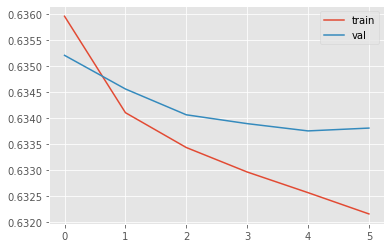

In [12]:
for label, y in loss_hist.items():
    plt.plot(y, label=label)

plt.legend()

In [33]:
real, pred = [], []
with torch.no_grad():
    model.eval()

    for wl, ll, data, labels in tqdm(test_loader, leave=False):
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = torch.sigmoid(model(wl, ll, data).squeeze())
        for i, x in enumerate(wl):
            real += [int(x) for x in labels[i,:x.item()].detach().cpu().numpy().tolist()]
            pred += [round(x) for x in outputs[i,:x.item()].detach().cpu().numpy().tolist()]

In [40]:
print(classification_report(real, [round(x) for x in pred]))

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89    258936
         1.0       0.83      0.06      0.11     68659

    accuracy                           0.80    327595
   macro avg       0.81      0.53      0.50    327595
weighted avg       0.81      0.80      0.72    327595

